# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


# Parameters

In [263]:
m=1
p = 0.2
q = 0#0.9#0.01#0.5 #Pure SF is q=0
run = 1

1

Choose your grid

In [264]:
global compactified=true
global loggrid=false
global bisection=false
global zeroformat=false
global twod=true

true

In [265]:
using Quadmath, Printf

res=m;
N=2.0^m*500.0/2.0

if compactified==true
    Xf=1.0
else
    Xf=20.0
end

dx=Xf/N
if loggrid==false
    dt=0.5*round(dx,digits=10)
else
    dt=0.1*round(dx,digits=10)
end
Nt=2.0^m*500.0/2.0
Tf=Nt*dt;

In [266]:
print(N)

500.0

In [267]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA"

# Grid

In [268]:
using Printf
include("./YangMills.jl");

In [269]:
ori=0.0#Float128(0.0)#0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

if loggrid==true
    global originalX=initX
    xtilde=gridfunc(initX1)
    initX1=xtilde
    initX=collect(initX)
    initX[4:L-3]=xtilde
end;

step size is  0.002
the time step is 0.001


# Initial data of m β Ψ and Ψ,x

In [270]:
using Dierckx


####

initm=zeros(L)
initbeta=zeros(L)
initpsi=zeros(L)
initxchi=zeros(L)
initderxchiu=zeros(L)
initderpsi=zeros(L)
initderxchi=zeros(L)


#state array is m beta psi xchi xchi,u psi,r xchi,r r
state_array=[initm initbeta initpsi initxchi initderxchiu initderpsi initderxchi initX];

#PSI,R
A=0.075*p*(1−q)
r0=0.75
sigma=0.25

initderpsi[4:L-3] = init_derpsi(initX1,r0,sigma,A)

state_array[:,6] = initderpsi
state_array=ghost(state_array)

#RCHI,R
A=0.25*p*q
r0=0.3
sigma=0.1

initderxchi[4:L-3] = init_derxchi(initX1,r0,sigma,A)

state_array[:,7] = initderxchi

####
#PSI FROM PSI,R, CHI FROM CHI,R
derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,6],  k=4);
derxchi_func = Spline1D(initX[4:L-3], state_array[4:L-3,7],  k=4);

funcs=[derpsi_func derxchi_func];

In [271]:
y0=[0.0 0.0 0.0 0.0 0.0]

state_array[4:L-3,1:5] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,funcs,state_array[:,:]);

#state_array = ghost(state_array);

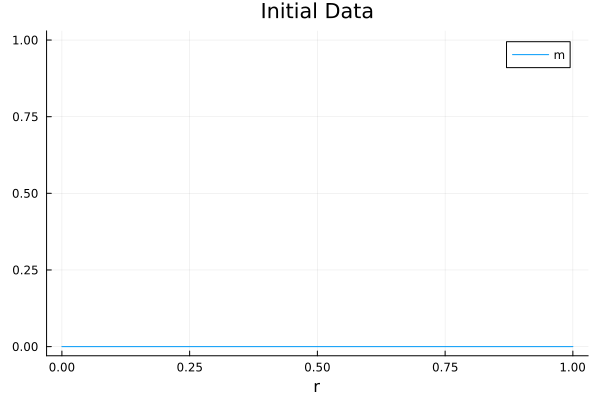

In [281]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], state_array[4:L-3,7], xaxis="r",title="Initial Data", labels=["m" "beta" "psi" "xchi" "xchi,u" "psi,r" "chix,r"])#,ylim=[-0.1,0.1])

In [273]:
state_array

507×8 Matrix{Float64}:
 0.0          0.0           0.0          0.0  0.0  0.0          0.0  -0.006
 0.0          0.0           0.0          0.0  0.0  0.0          0.0  -0.004
 0.0          0.0           0.0          0.0  0.0  0.0          0.0  -0.002
 0.0          0.0           0.0          0.0  0.0  1.85115e-6   0.0   0.0
 5.42836e-17  4.49828e-14   3.89225e-9   0.0  0.0  2.0354e-6    0.0   0.002
 3.28132e-16  1.32295e-13   8.18444e-9   0.0  0.0  2.2333e-6    0.0   0.004
 1.13915e-15  2.91034e-13   1.29083e-8   0.0  0.0  2.44578e-6   0.0   0.006
 2.87807e-15  5.35457e-13   1.80977e-8   0.0  0.0  2.67379e-6   0.0   0.008
 6.03967e-15  8.81503e-13   2.37892e-8   0.0  0.0  2.91838e-6   0.0   0.01
 1.12442e-14  1.34743e-12   3.00218e-8   0.0  0.0  3.18065e-6   0.0   0.012
 1.9262e-14   1.95417e-12   3.68372e-8   0.0  0.0  3.46174e-6   0.0   0.014
 3.10423e-14  2.72572e-12   4.42802e-8   0.0  0.0  3.76292e-6   0.0   0.016
 4.77465e-14  3.68952e-12   5.23988e-8   0.0  0.0  4.08548e-6   0.0 

In [274]:
function compactify(r)
    return r/(1+r)
end
function uncompactify(x)
    return x/(1-x)
end;

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [275]:
using CSV, Tables
#CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "xchi", "deruxchi", "derpsi", "derxchi"]

print_muninn(files, 0, state_array[:,:],res,"w")

In [276]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
global monitor_ratio = zeros(L);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

In [277]:
ginit=speed(initX,state_array[:,1],state_array[:,2])
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

0.40160481283206273


In [278]:
using Base.Threads
Threads.nthreads()

4

In [279]:
if m==1
    global dt=2e-8
elseif m==2
    global dt=1e-6
else
    global dt=1e-6/2
end

2.0e-8

 ## Time evolution

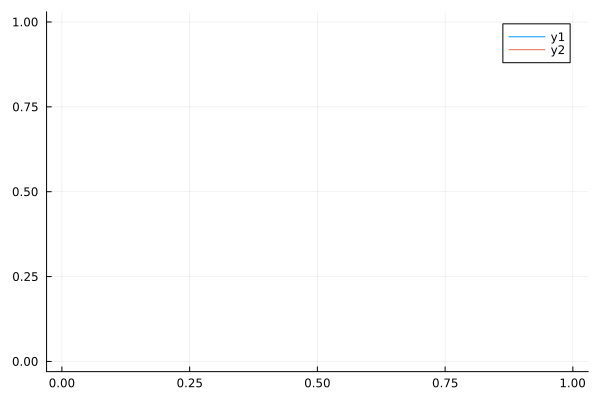

In [282]:
#import PlotlyJS()

yy=zeros(L)
for i in 4:L-3
    yy[i]=dissipation(state_array,i,0.02)[7]
end
plot(initX1, [log.(abs.(state_array[4:L-3,7])) log.(abs.(yy[4:L-3]))])#,xlim=[0, 0.5],ylim=[-20,1])
plot(initX1, [log.(abs.(state_array[4:L-3,7])) .(yy[4:L-3]))])#



In [254]:
import Pkg;
Pkg.add("PlotlyJS")

   Resolving package versions...
   Installed EpollShim_jll ─ v0.0.20230411+0
   Installed xkbcommon_jll ─ v1.4.1+1
   Installed Wayland_jll ─── v1.21.0+1
  No Changes to `~/.julia/environments/v1.8/Project.toml`
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [2702e6a9] + EpollShim_jll v0.0.20230411+0
  [a2964d1f] ↑ Wayland_jll v1.21.0+0 ⇒ v1.21.0+1
  [d8fb68d0] ↑ xkbcommon_jll v1.4.1+0 ⇒ v1.4.1+1
Precompiling project...
  ✓ EpollShim_jll
  ✓ Wayland_jll
  ✓ xkbcommon_jll
  ✓ Qt5Base_jll
  ✓ GR_jll
  ✓ GR
  ✓ Plots
  7 dependencies successfully precompiled in 79 seconds. 270 already precompiled.
  6 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


In [236]:
state_array[:,6]

507-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.8511470613001934e-6
 2.0353955232434885e-6
 2.2333015411563054e-6
 2.4457778148048348e-6
 2.6737949462713214e-6
 2.918384988655291e-6
 3.1806452055886227e-6
 3.461742053629519e-6
 3.762915400254031e-6
 4.085482990850214e-6
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

fixed grid

In [214]:
finaltime=3.0
evol_stats, T_interp = timeevolution(state_array,finaltime,run);
#CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);

-1.2835694809917155e-33 -1.40494329157128e-34 -1.4324572410557386e-35 -1.3570616630859926e-36 -1.1914551511777701e-37 -9.667905003614557e-39 -7.2298389975328455e-40 -4.967952607276782e-41 -3.127036317434524e-42 -7.757272911940172e-6 1.5227084298324867e-8 -6.671133825075781e-6 5.080145314834139e-9 -1.7971702524542975e-43 -6.093878275256759e-9 -9.398905667466453e-45 -5.500402832786522e-6 -4.457192930815503e-46 -1.835059516668014e-8 -4.2620849596830546e-6 -3.174577468956219e-8 -1.909570047128349e-47 -4.633499231000704e-8 -2.974763173915762e-6 -6.217322576912432e-8 -7.362400224872366e-49 -1.658261698789243e-6 -2.544216478349735e-50 -7.931440540800971e-8 -9.781090719480912e-8 -7.846891559407187e-52 -1.1771299946936042e-7 -1.3906822316986367e-7 -1.619207183438387e-7 -3.3326521264864795e-7 -2.1504063109033737e-53 -1.863104854941955e-7 -5.211948067053208e-55 9.79098151859814e-7 -1.1117708287103055e-56 -2.122725812660209e-7 2.2577004609933282e-6 -2.0765422430932226e-58 -2.3983625179607726e-7 -2

-6.63838350740964e-6 4.496383473884258e-9 5.400048579902629e-10 8.051583713146355e-24 7.872981844789066e-24 -5.466965840722482e-6 5.815795461603126e-10 -6.719678277353203e-9 -4.228463890976197e-6 7.698636616720684e-24 6.172149931889259e-10 -2.941469288836318e-6 7.528438039082083e-24 -1.9019729940311647e-8 6.549396766429181e-10 7.362279407650627e-24 -1.625804628563321e-6 -3.2459442850588105e-8 6.949156703030466e-10 -4.7094274920750356e-8 7.372553599576496e-10 7.200056739542686e-24 -6.297906584261381e-8 7.820931543152217e-10 7.041669135288474e-24 -3.0214234607306434e-7 -8.016758558208881e-8 1.0084123077541696e-6 6.887018449498026e-24 8.295706682636428e-10 2.284764681510787e-6 -9.871202589703532e-8 3.506289608795621e-6 6.736009192638769e-24 4.653293692036264e-6 6.5885486196283006e-24 -1.1866244520840341e-7 8.798370823806076e-10 6.4445465045005866e-24 5.70746810202305e-6 9.330494950452213e-10 6.3039150364057424e-24 6.652318645071487e-6 9.893733064107404e-10 6.1665689428695505e-24 -1.400661

6.904934720134911e-8 5.962292278921533e-6 9.832578258993299e-25 -9.690874824138492e-17 7.061234136252967e-8 -3.5927473444909423e-17 7.209554136848595e-8 5.678904016464398e-6 7.34844056611561e-8 9.636964152440826e-25 -1.2912247204322156e-17 5.328332362743854e-6 7.476316988457368e-8 -4.494499246514899e-18 4.909652199912989e-6 9.445317527401475e-25 -1.513706668603436e-18 7.591478247892178e-8 4.422723461341635e-6 7.692084243865471e-8 9.257553312615568e-25 -4.927663015738795e-19 3.868264342767047e-6 9.073588390288151e-25 7.776153634203586e-8 -1.5488592185075e-19 3.247917532860946e-6 8.893341549069221e-25 7.841557629791052e-8 2.5643074804521625e-6 7.886013976164327e-8 1.8210865218061534e-6 7.907081123539883e-8 8.716733425598742e-25 -4.695065645839649e-20 1.0229678422402078e-6 7.90215266268865e-8 8.543686475279152e-25 -1.3705643590401557e-20 1.7574310623089118e-7 7.86845215589374e-8 8.37412491114966e-25 -3.843862134394974e-21 7.803028403974288e-8 -7.137171387575081e-7 -1.0298768062096024e-21 

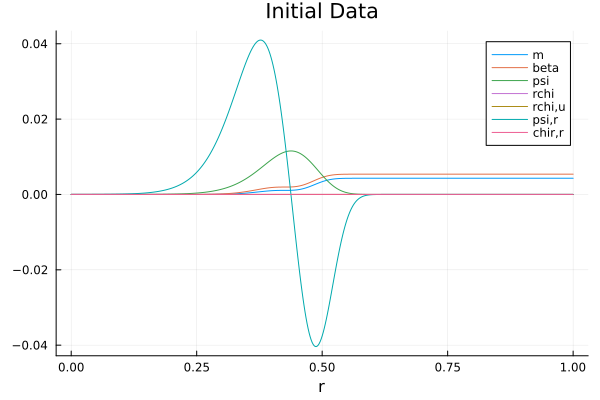

In [141]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], state_array[4:L-3,1:7], xaxis="r",title="Initial Data", labels=["m" "beta" "psi" "rchi" "rchi,u" "psi,r" "chir,r"])#,ylim=[-0.1,0.1])

#### 

 ## Movie of the evolution, apparent horizon formation for 0.0492<A*<0.04925

In [336]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 710:710
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.01, 0.01],xlim=[0.0, 0.1])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA/res1/time_step710.csv" is not a valid file or doesn't exist

In [49]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8000:100:10000
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot6=functions3.Column1[4:L-3] .* 2 .* (1 .- functions3.Column5[4:L-3]) ./functions3.Column5[4:L-3];
    
    
    plot!(initX1, plot6, labels=["monitor ratio"], ylim=[-1.3, 0.6],xlim=[0.0, 0.3])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step8000.csv" is not a valid file or doesn't exist

In [50]:
dir

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

In [141]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8200:5:8430
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1],xlim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1500)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/monitor_ratio8200.csv" is not a valid file or doesn't exist

Sanity check for der func

In [207]:
array=init_gaussian(originalX,0.7,0.3,0.01)
arrayloggrid=init_gaussian(initX,0.7,0.3,0.01);

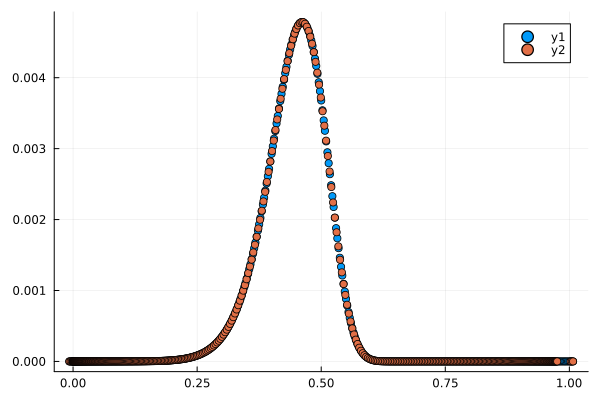

In [209]:
scatter([originalX, initX], [array, arrayloggrid])

In [210]:
aux=zeros(L)

loggrid=false
for i in 4:L-3
    aux[i]=Dertest(array,i,originalX)
end
x1=originalX
y1=aux


loggrid=true
for i in 4:L-3
    aux[i]=Dertest(arrayloggrid,i,initX)
end
x2=initX
y2=aux;

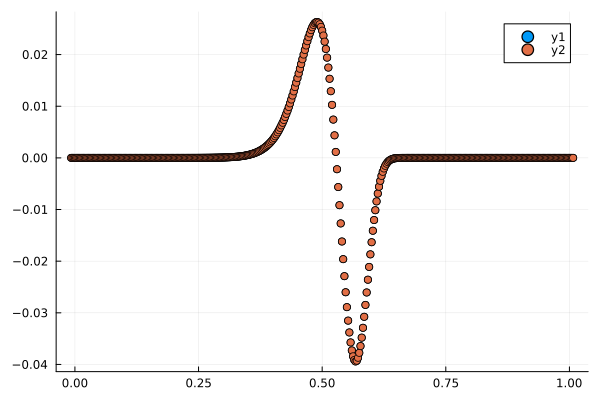

In [417]:
scatter([x1,x1],[y1,y2])